<a href="https://colab.research.google.com/github/bsussel3/2023-s1-ci/blob/main/solucao/roteiro_atividade_02_EA991_1s2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 02: Reconhecimento de Atividades Humanas com kNN, SVM e _Random Forest_

<img src="https://github.com/EA991-Lab/utils/blob/main/figs/HAR_acc_gyr.png?raw=true">

*Dataset*: DAGHAR - https://zenodo.org/records/13987073

Github: https://github.com/H-IAAC/DAGHAR

O *benchmark* DAGHAR é uma coleção curada de conjuntos de dados projetada para estudos de adaptação de domínio e generalização de domínio em tarefas ligadas ao reconhecimento de atividades humanas (HAR, do inglês *human activity recognition*). As amostras disponíveis contêm dados brutos de sensores inerciais (acelerômetro e giroscópio) provenientes exclusivamente de *smartphones*.

Nesta atividade, vamos trabalhar com a *baseline view* do DAGHAR, que preserva ao máximo as características dos *datasets* originais (como a taxa de amostragem).

**Informações padronizadas:**

- 6 classes

| Rótulo    | Atividade |
| :----:    |    :---   
| 0   | Estar sentado       
| 1   | Ficar em pé        
| 2   | Caminhar        
| 3   | Subir escadas      
| 4   | Descer escadas
| 5   | Correr      

- Cada amostra contém janelas de 3 segundos (sem sobreposição) concatenadas de Acc-x, Acc-y, Acc-z, Gyr-x, Gyr-y, Gyr-z.



## Preâmbulo: Baixando o DAGHAR _baseline_

In [1]:
import requests
import os
from pathlib import Path
from zipfile import ZipFile

# Caminho para a pasta que conterá o dataset
data_path = Path("data/")

def get_DARGHAR_data():
    if not os.path.exists(data_path):
        os.makedirs("data/", exist_ok=True)

        # Baixando o dataset do Zenodo
        data_url = "https://zenodo.org/records/13987073/files/baseline_view.zip?download=1"
        print(f"Baixando dados de {data_url}...")

        #Baseline view
        with open("baseline_view.zip", "wb") as f:
            request = requests.get(data_url)
            f.write(request.content)

        # Unzip
        targ_dir = "data"
        print(f"Extraindo dados para {targ_dir}...")
        with ZipFile("baseline_view.zip") as zip_ref:
            zip_ref.extractall(targ_dir)
    else:
        print("Dataset já baixado!")

#Baixando o dataset DAGHAR completo
get_DARGHAR_data()

Baixando dados de https://zenodo.org/records/13987073/files/baseline_view.zip?download=1...
Extraindo dados para data...


## Parte 1: Conhecendo detalhes do problema e do *dataset*

Escolha um conjunto de dados que compõe o DAGHAR e faça o carregamento das partições de treinamento, validação e teste.

**Passos:**
- definir o nome do subdiretório correspondente ao *dataset*;
- ler os arquivos `train.csv`, `validation.csv` e `test.csv`.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
#Caminho para a pasta que conterá o dataset
folder = "KuHar"
dataset_path = data_path / folder

#Leitura das partições de treinamento, validação e teste
data_train = pd.read_csv(dataset_path / "train.csv")
data_val = pd.read_csv(dataset_path / "validation.csv")
data_test = pd.read_csv(dataset_path / "test.csv")

print(f"Dimensão do dataset de treinamento: {data_train.shape}")
print(f"Dimensão do dataset de validação: {data_val.shape}")
print(f"Dimensão do dataset de teste: {data_test.shape}")


Dimensão do dataset de treinamento: (1386, 1812)
Dimensão do dataset de validação: (426, 1812)
Dimensão do dataset de teste: (144, 1812)


In [5]:
#Lista com os nomes das classes na ordem correspondente aos rótulos numéricos
class_names = ['Sitting','Standing','Walking','Upstairs','Downstairs','Running']

#mapeamento dos rótulos padronizados para os nomes das classes no DAGHAR
label_map = {0:'Sitting',1:'Standing',2:'Walking',3:'Upstairs',4:'Downstairs',5:'Running'}

O `DataFrame` correspondente a cada *dataset* contém colunas adicionais com informações específicas (como índice de usuário) que não serão exploradas na atividade. Por isso, é necessário realizar uma limpeza inicial a fim de reter apenas as medidas de acelerômetro e giroscópio juntamente com o rótulo da atividade.

a) Sorteie aleatoriamente uma amostra de cada classe e apresente as séries temporais correspondentes aos três eixos de acelerômetro e de giroscópio. Discuta brevemente o perfil das atividades com base nestas séries temporais.

b) No problema de HAR, a representação no domínio da frequência para cada sinal (Acc-x, Acc-y, ..., Gyr-z) tende a favorecer a separação das classes, levando a um agrupamento das amostras de acordo com a "energia" da atividade. Por isso, vamos aplicar a transformada de Fourier a cada sinal básico (Acc-x, Acc-y, $\ldots$, Gyr-z) e gerar um vetor de características formado pela concatenação da magnitude dos espectros:

$$\text{Vetor de atributos} = [\, |\text{DFT}(\text{Acc-x})|\;,\;|\text{DFT}(\text{Acc-y})|\;,\;|\text{DFT}(\text{Acc-z})|\;,\; |\text{DFT}(\text{Gyr-x})|\;,\; |\text{DFT}(\text{Gyr-y})|\;,\; |\text{DFT}(\text{Gyr-z})|]$$

Prepare, então, uma rotina que faça esta transformação das partições de treinamento, validação e teste. Em seguida, mostre a magnitude dos espectros das amostras selecionadas no item anterior (uma por atividade) e comente.

c) Utilizando o algoritmo t-SNE (https://www.jmlr.org/papers/v9/vandermaaten08a.html), obtenha uma visualização em duas dimensões dos dados de treinamento e validação combinados.

**Sugestão:** utilize o `plotly.express` para gerar uma figura interativa; cada amostra será um ponto no espaço bidimensional cuja cor deve indicar a atividade humana correspondente.

### a)

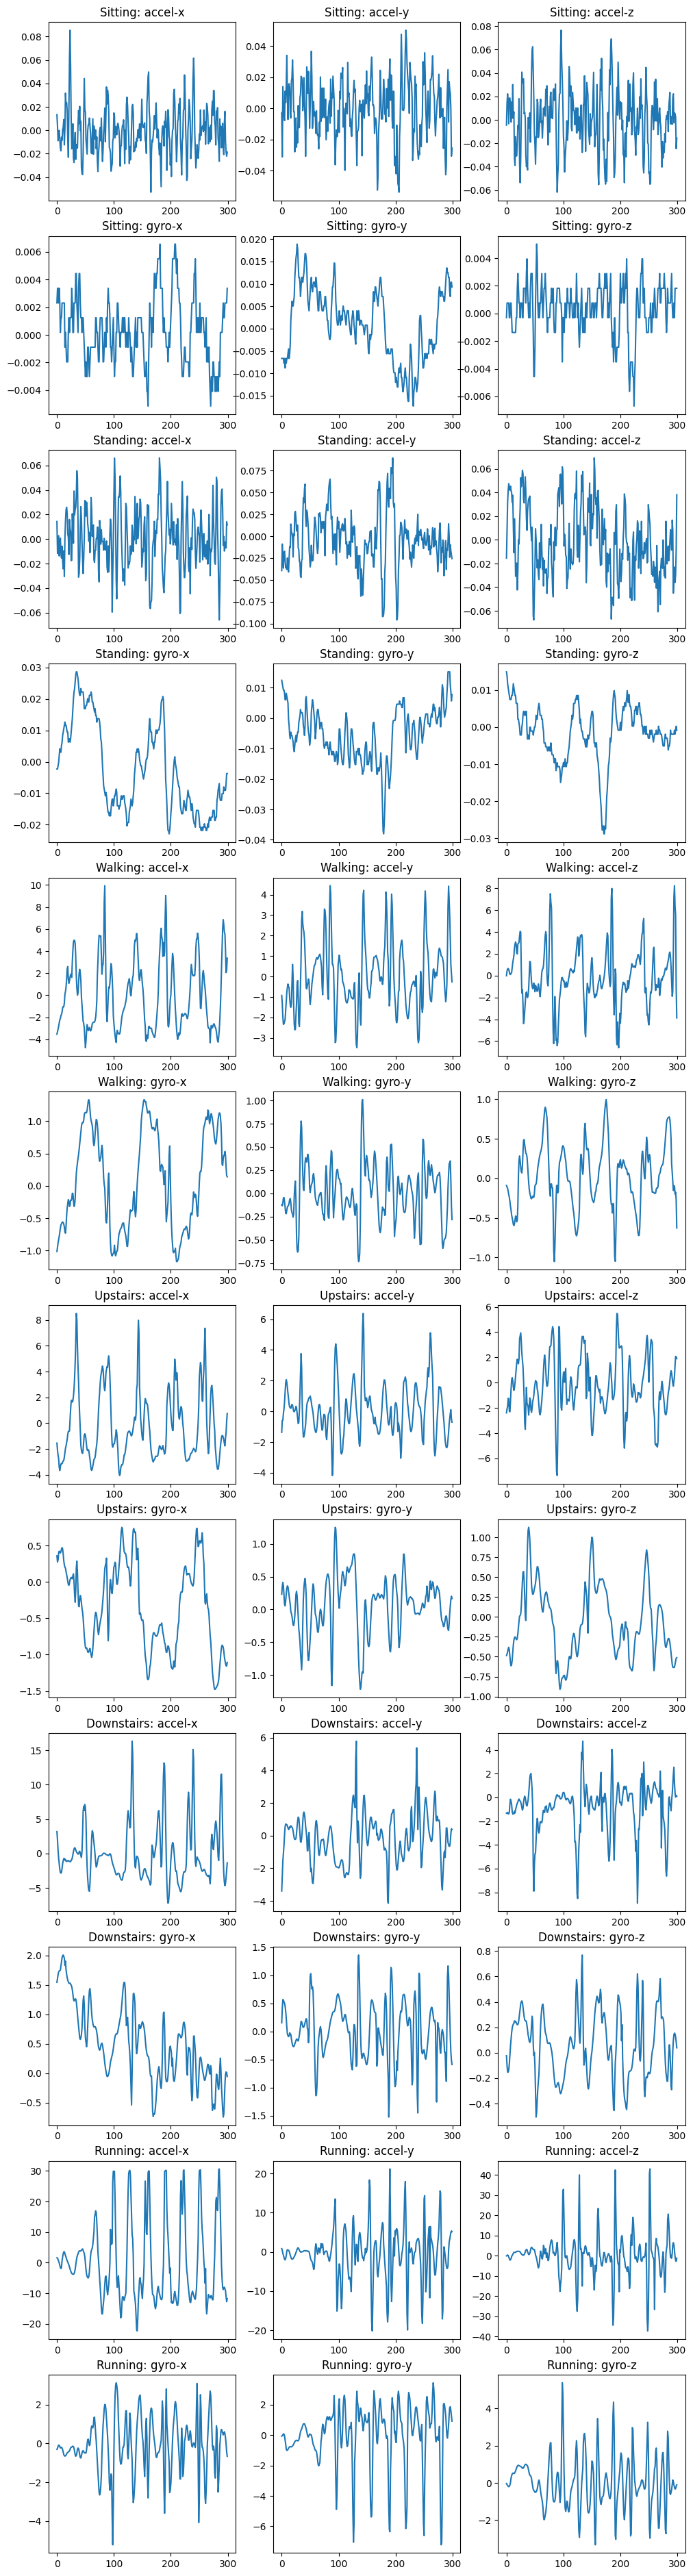

In [52]:
sensors = ('accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z')

fig, axs = plt.subplots(12, 3, figsize=(12, 48))

index_ax = 0
for code in label_map.keys():
    filtered_train = data_train[data_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-299'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(300), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

### b)

In [102]:
def fft_transform(df):
    data = None
    for sensor in sensors:
        sensor_data = np.absolute(np.fft.fft(df.loc[:,sensor+'-0':sensor+'-299']))
        if data is None:
            data = sensor_data
        else:
            data = np.concatenate((data, sensor_data), axis=1)

    filler = df.loc[:,'gyro-end-time':'standard activity code']
    data = np.concatenate((data, filler), axis=1)
    fft_df = pd.DataFrame(data, columns=df.columns)

    return fft_df

fft_train = fft_transform(data_train)
fft_val = fft_transform(data_val)
fft_test = fft_transform(data_test)

print(f"Dimensão do dataset de treinamento: {fft_train.shape}")
print(f"Dimensão do dataset de validação: {fft_val.shape}")
print(f"Dimensão do dataset de teste: {fft_test.shape}")

Dimensão do dataset de treinamento: (1386, 1812)
Dimensão do dataset de validação: (426, 1812)
Dimensão do dataset de teste: (144, 1812)


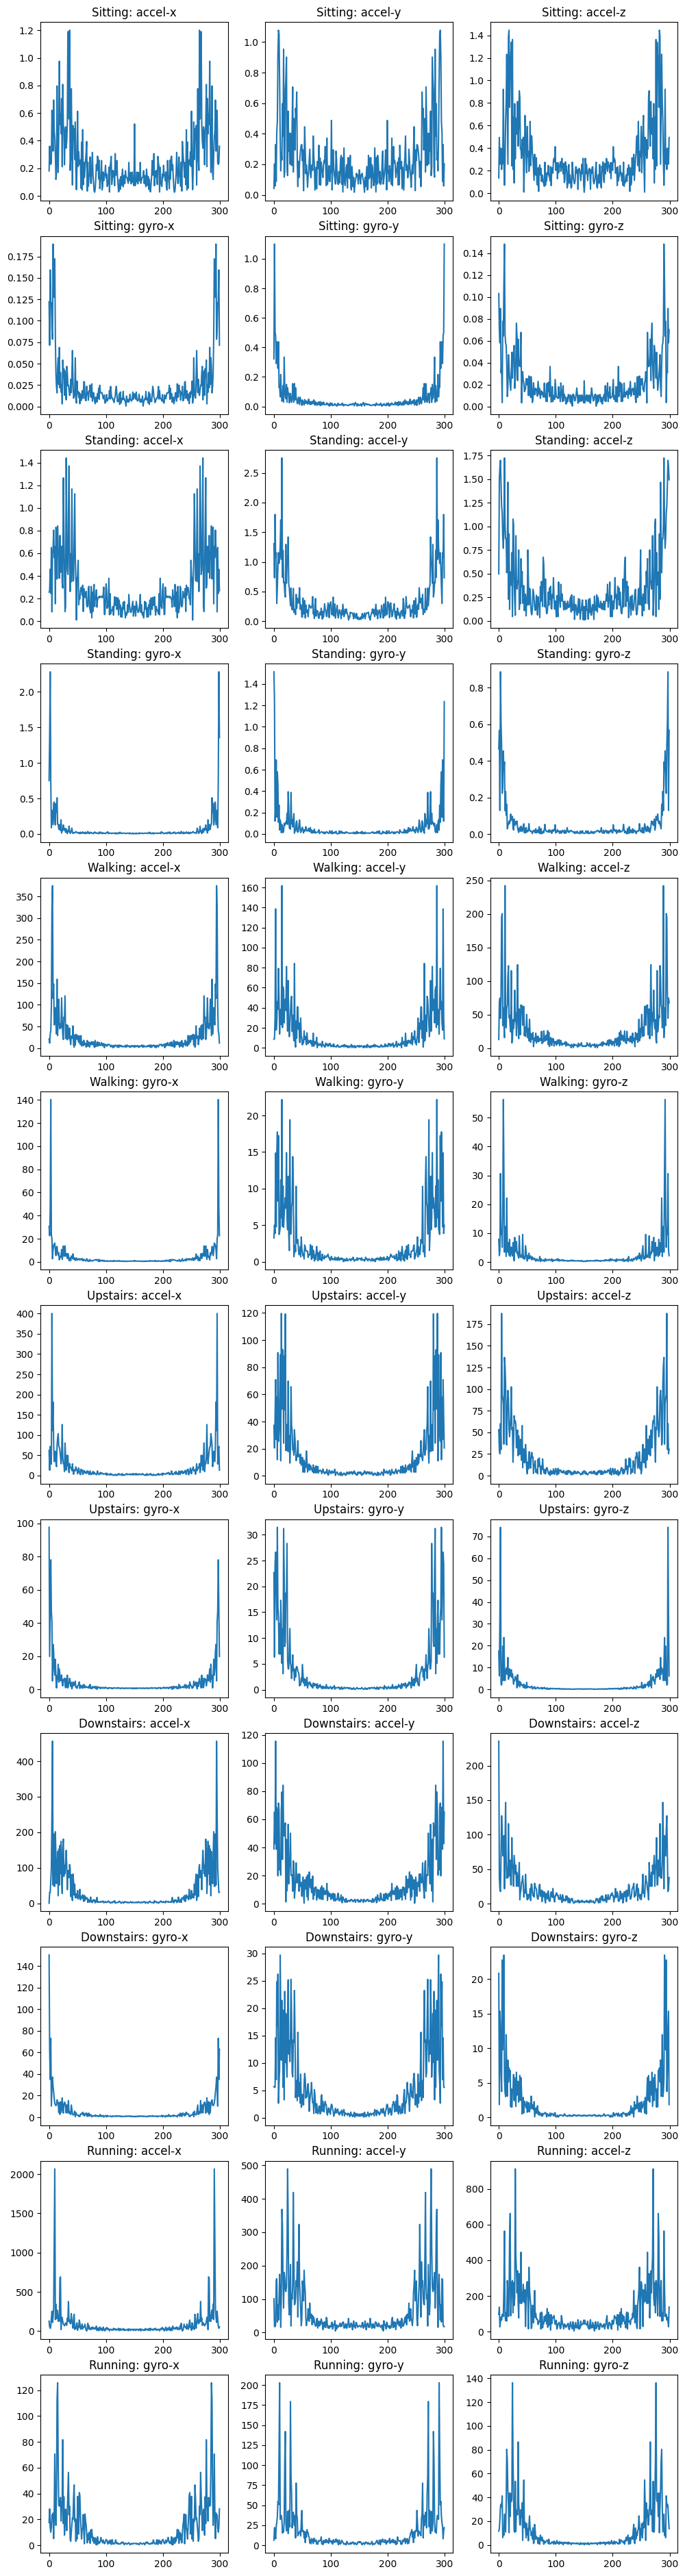

In [103]:
fig, axs = plt.subplots(12, 3, figsize=(12, 48))

index_ax = 0
for code in label_map.keys():
    filtered_train = fft_train[fft_train['standard activity code'] == code]
    sample = filtered_train.sample(random_state=42)
    for sensor in sensors:
        values = sample.loc[:,sensor+'-0':sensor+'-299'].values.T
        ax = axs.flat[index_ax]
        ax.plot(np.arange(300), values)
        ax.set_title(f"{label_map[code]}: {sensor}")

        index_ax += 1

plt.show()

### c)

In [107]:
pd.concat((fft_train, fft_val)).loc[:,'accel-x-0':'gyro-z-299'].shape

(1812, 1800)

In [109]:
from sklearn import manifold

""" Vamos usar uma técnica chamada t-SNE para mapear os dados numa representação 2D de forma não-linear buscando preservar as relações
    de vizinhança (probabilística) entre as amostras.
"""
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    #init="random",
    #random_state=0,
)

fft_concat_train = pd.concat((fft_train, fft_val))
X_t_sne = t_sne.fit_transform(fft_concat_train.loc[:,'accel-x-0':'gyro-z-299'])

#DataFrame com o resultado do t-SNE
tsne_result = pd.DataFrame(X_t_sne,columns=['tsne1','tsne2'])

In [110]:
tsne_result.head()

,tsne1,tsne2
0,-46.908775,-9.003184
1,-27.177364,-8.046613
2,-29.474167,-1.273857
3,-35.099964,5.560667
4,-49.403423,-7.391185


In [113]:
import plotly.express as px

fig = px.scatter(tsne_result, x='tsne1', y='tsne2', color=fft_concat_train["standard activity code"] ,labels={'color': 'Atividade'})

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.8
))

fig.show()

## Parte 2: Aplicação de SVM

Ajuste de hiperparâmetros com busca em grade e validação cruzada (*holdout*) + aplicação ao conjunto de teste

**Nota:** para usar um conjunto de validação pré-estabelecido junto ao `GridSearchCV`, é preciso:
1. Concatenar as partições de treinamento e validação;
2. Criar uma lista de índices 0 e -1 de mesmo tamanho que o total de amostras de treinamento + validação: os 0s aparecem para as amostras de validação, e -1s para as amostras de treinamento;
3. Usar `PredefinedSplit` com a lista de índices para preparar um separador de dados de validação;
4. Passar o *splitter* através do parâmetro `cv` do `GridSearchCV`.

In [133]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score

d) Apresente uma curva de variação de uma métrica de desempenho (e.g., $F_1$-*score*) nos dados de validação em função da largura da função *kernel* considerando a opção de *kernel* Gaussiano (ou `rbf`). Comente.

e) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.


In [134]:
data_train.head()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-start-time,index,user,serial,accel-start-time,csv,timestamp diff,activity code,window,standard activity code
0,-0.044137,-0.071939,-0.059459,-0.009567,-0.028807,-0.019420,-0.005382,-0.003268,-0.010541,-0.010532,...,12.141000,1201.0,1077.0,1,12.140000,0.Stand/1077_A_1.csv,0.008000,0,4,1
1,0.076250,0.077858,0.072395,0.067158,0.000937,-0.049944,-0.106950,-0.120721,-0.089627,-0.063963,...,39.441002,3901.0,1065.0,1,39.441002,0.Stand/1065_A_1.csv,0.010002,0,13,1
2,-0.022714,-0.034023,-0.002826,-0.018109,-0.029658,-0.013994,-0.031590,-0.018254,0.003103,-0.004098,...,40.537998,3901.0,1032.0,1,40.539001,0.Stand/1032_A_1.csv,0.018002,0,13,1
3,-0.011004,-0.008461,0.001106,0.019939,0.026677,-0.004387,0.009816,0.002581,-0.018661,-0.018351,...,43.363998,3301.0,1071.0,1,43.362999,0.Stand/1071_A_1.csv,0.008999,0,11,1
4,-0.029378,-0.017133,-0.007478,-0.007424,-0.004992,0.002110,0.013817,-0.002918,0.013626,-0.012510,...,21.242001,2101.0,1053.0,1,21.250999,0.Stand/1053_A_1.csv,0.008999,0,7,1


In [119]:
X_train = fft_train.loc[:,'accel-x-0':'gyro-z-299']
X_val = fft_val.loc[:,'accel-x-0':'gyro-z-299']
X_test = fft_test.loc[:,'accel-x-0':'gyro-z-299']

y_train = fft_train['standard activity code']
y_val = fft_val['standard activity code']
y_test = fft_test['standard activity code']

X_train_val = pd.concat((X_train, X_val))
y_train_val = pd.concat((y_train, y_val))

In [131]:
n_features = X_train_val.shape[1]

np.log10(1 / n_features)


np.float64(-3.255272505103306)

In [135]:
n_features = X_train_val.shape[1]

# Define o grid de parâmetros
param_grid = {
    'C': np.logspace(-1, 1, 3),
    'gamma': np.logspace(-6, 0),
    'kernel': ['rbf', 'sigmoid']
}

#lista de índices para a separação novamente em X_train e X_val dentro do GridSearch
split_index = [-1]*len(X_train) + [0]*len(X_val)

#cria o splitter de dados
pds = PredefinedSplit(test_fold = split_index)

#define a busca em grade
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=pds,
)


## Parte 3: Aplicação de kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

f) Mostre em um gráfico a variação da mesma métrica de desempenho no conjunto de validação em função do número de vizinhos ($k$). Comente.

g) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.

## Parte 4: Aplicação de *Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

h) Mostre o impacto do número de árvores (`n_estimators`) sobre o desempenho de validação considerando como função de impureza (`criterion`) o índice de Gini e a entropia. Comente.

i) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: acurácia, $F_1$-*score* e matriz de confusão.

## Parte 5: Extensão para outros dois *datasets*

j) Repita o procedimento adotado nas Partes 1 a 4 para outros dois *datasets* de sua escolha contidos no DAGHAR. Ao final de todos os passos, mostre numa tabela os desempenhos de teste alcançados pelos modelos nos três *datasets*.

| Modelo    | *Dataset* 1 | *Dataset* 2 | *Dataset* 3 |  Média e Desvio Padrão
| :----:    |    :---   |    :---   |    :---   | :---   
| SVM   |        
| kNN |        
| *Random Forest* |

k) Aplique, ao final, um teste estatístico não-paramétrico (e.g., Wilcoxon) em todos os pares de modelos - SVM vs. kNN, SVM vs. *Random Forest* e kNN vs. *Random Forest* e obtenha os p-valores. Verifique se há diferença que possa ser considerada significativa entre eles.
